# 高斯混合模型GMM——解决幸存者偏差

- 用于欺诈检测：在欺诈检测模型训练前，由于大部分样本没有欺诈标签，通常使用聚类方法将用户聚成不同的簇，而后根据簇中有标签的用户性质定义该簇的整体性质。
- 用于用户分层：将样本集按照特征属性划分为不同的子类，之后再每个子类中分别建模，以获得更好的整体表现。

## 使用GMM进行聚类

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [4]:
import warnings
warnings.filterwarnings('ignore')

产生实验数据

In [5]:
from sklearn.datasets.samples_generator import make_blobs

使用GMM对原始数据进行聚类

In [6]:
X, y_true = make_blobs(n_samples=700, centers=4,  
             cluster_std=0.5, random_state=2019)
X = X[:, ::-1]

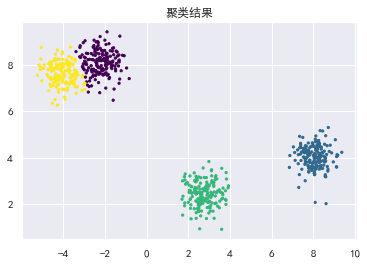

In [7]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=4).fit(X) # n_components：聚类中心个数
labels = gmm.predict(X)

#中文标题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.title('聚类结果')
plt.scatter(X[:,0], X[:,1], c=labels, s=5, cmap='viridis')

结果：样本点被聚类成4个圆形的分布簇

## GMM中的概率模型

可以通过GMM算法中的概率模型得到簇的分配结果的概率。

### 1. 概率矩阵

In [8]:
# 打印前十个点分别属于4个类的概率
probs = gmm.predict_proba(X)
print(probs[:10].round(2))

[[0.   1.   0.   0.  ]
 [0.96 0.   0.   0.04]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]]


### 2. 概率可视化

In [9]:
size = probs.max(1)

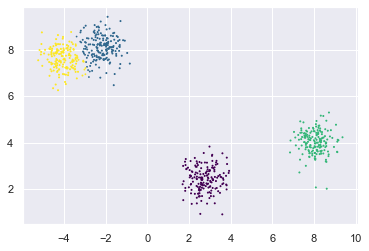

In [10]:
plt.scatter(X[:,0], X[:,1], c=labels, s=size, cmap='viridis')

结果：因为GMM并不是通过硬截断进行类别分割，而是通过高斯平滑模型进行估计，所以将每个点的概率进行可视化时，散点图并不是严格椭圆形。

### 3. 生成椭圆形的数据集并使用GMM进行聚类

In [10]:
from matplotlib.patches import Ellipse

In [11]:
# 根据给定位置和协方差，构造一个画椭圆的函数
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    # 将协方差转换为主轴
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2*np.sqrt(s)
    else:
        angle = 0
        width, height = 2*np.sqrt(covariance)
        
    # 画出椭圆
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle, **kwargs))

In [12]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=4, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=4, zorder=2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    for pos,covar,w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### 4. 使用椭圆形来拟合数据

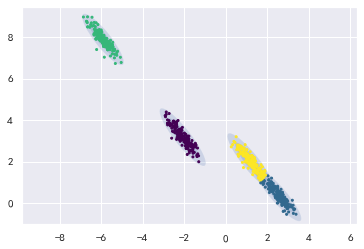

In [13]:
rng = np.random.RandomState(13)
X_st = np.dot(X, rng.randn(2,2))
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_st)

结论：可以拟合任意形状的分布，GMM的聚类效果非常好。

## GMM样本生成

由于GMM是一个生成式模型，当拟合一个GMM后，可以从该模型的每一个分布成分中生成服从该分布的新样本，具有强大的样本生成能力。

### 1. 构造一个非常规的分布形式

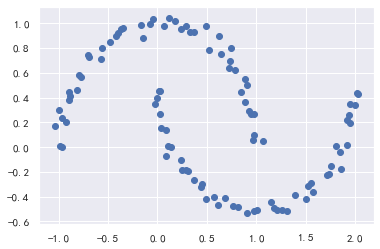

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(100, noise=.04, random_state=0)
plt.scatter(Xmoon[:,0], Xmoon[:,1])

### 2. 通过两个高斯分布进行聚类

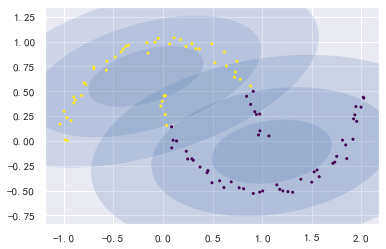

In [15]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

结论：从图中可以看出，一部分点被错误归类为另一个分布。需要使用更多的高斯分布进行归纳，更准确地描述数据分布。

### 3. 使用十个高斯混合成分进行聚类

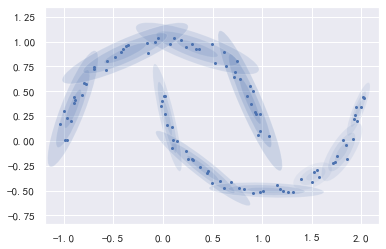

In [16]:
gmm10 = GMM(n_components=10, covariance_type='full', random_state=0)
plot_gmm(gmm10, Xmoon, label=False)

结论：通过十个分布进行集成得到最终的归纳结果，GMM的本质并不是聚类，而是得到一个能够生成当前样本形式的分布。

### 4. 生成新样本

使用10个高斯分布集成的生成模型gmm10，来生成服从当前分布形式的新样本。

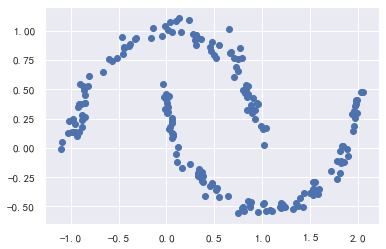

In [17]:
Xnew = gmm10.sample(200)[0] # 生成服从现有分布的200个新样本
plt.scatter(Xnew[:,0], Xnew[:,1])

结论：新生成的样本服从之前的分布，但是与之前的样本点并不重合。因此只需要根据历史样本进行聚类，得到生成模型，再利用生成模型生成新的样本点，并带入现有样本集进行协同训练。因为新生成的样本点与旧样本点服从相同分布，但不完全重合，所以训练的模型有更强的泛化能力。

# 确定GMM高斯混合成分个数

信息准则：通过加入模型复杂度的惩罚项来避免过拟合问题。
- AIC 赤池信息准则：衡量统计模型拟合优良性的一种标准
- BIC 贝叶斯信息准则：用于模型选择

In [18]:
n_components = np.arange(1,21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

Text(0.5, 0, 'n_component')

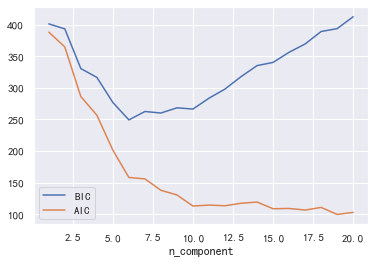

In [19]:
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_component')

结论：最佳的组件个数即是使得AIC或BIC最小化的值。BIC准则期望使用更少的高斯分布个数，在实际使用中可以增强模型的鲁棒性。通常不会使用太少的高斯分布组件进行聚类，否则难以生成有针对性的特征；为了防止生成模型的泛化能力较差，组件的个数通常不会超过20个。